### Outline

This Ipython notebook is focused on data preparation : fill missing values and multicollinearity in dataset

   * Missing Value 
   * Outlier 
   * Multicollinearity 
   * Simple Submission 

### Setup Imports and Variables

In [1]:
import pandas as pd
import numpy as np
import pylab as plt
import matplotlib.pyplot as plt
##import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
import numpy as np
import seaborn as sns
from scipy import stats
color = sns.color_palette()
%matplotlib inline
# Set the global default size of matplotlib figures
plt.rc('figure', figsize=(12, 5))

# Size of matplotlib figures that contain subplots
fizsize_with_subplots = (12,12)

# Size of matplotlib histogram bins
bin_size = 10

### Load the Data

In [83]:
df_train = pd.read_csv('./data/input/train.csv')
df_train.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,...,9,4,0,13,22,1,0,52,4,5850000
1,2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,...,15,3,0,15,29,1,10,66,14,6000000
2,3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,...,10,3,0,11,27,0,4,67,10,5700000
3,4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,...,11,2,1,4,4,0,0,26,3,13100000
4,5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,...,319,108,17,135,236,2,91,195,14,16331452


In [3]:
df_train.shape

(30471, 292)

In [77]:
df_test = pd.read_csv('./data/input/test.csv')
df_test.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000
0,30474,2015-07-01,39.0,20.7,2,9,1,1998.0,1,8.9,...,8,0,0,0,1,10,1,0,14,1
1,30475,2015-07-01,79.2,NaN,8,17,1,0.0,3,1.0,...,4,1,1,0,2,11,0,1,12,1
2,30476,2015-07-01,40.5,25.1,3,5,2,1960.0,2,4.8,...,42,11,4,0,10,21,0,10,71,11
3,30477,2015-07-01,62.8,36.0,17,17,1,2016.0,2,62.8,...,1,1,2,0,0,10,0,0,2,0
4,30478,2015-07-01,40.0,40.0,17,17,1,0.0,1,1.0,...,5,1,1,0,2,12,0,1,11,1


In [5]:
#basic variables
basic_feature = ['timestamp', 'full_sq', 'life_sq', 'floor', 'max_floor', 'material', 'build_year',
                 'num_room', 'kich_sq', 'state','product_type', 'sub_area']

In [6]:
df_train['build_year'].describe(include='all')

count    1.686600e+04
mean     3.068057e+03
std      1.543878e+05
min      0.000000e+00
25%      1.967000e+03
50%      1.979000e+03
75%      2.005000e+03
max      2.005201e+07
Name: build_year, dtype: float64

### Missing Value

In [7]:
#missing value
missing_build_count = df_train[df_train['build_count_1921-1945'].isnull()]
missing_build_count.shape

(4991, 292)

In [8]:
missing_df = missing_build_count.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.ix[missing_df['missing_count']>0]

In [9]:
missing_df.head()

,column_name,missing_count
3,life_sq,2698
4,floor,37
5,max_floor,1721
6,material,1721
7,build_year,3424


In [10]:
df_train['cafe_sum_500_max_price_avg'].describe()

count    17190.000000
mean      1247.023497
std        526.539159
min        500.000000
25%       1000.000000
50%       1166.670000
75%       1500.000000
max       6000.000000
Name: cafe_sum_500_max_price_avg, dtype: float64

In [11]:
df_train['state'].describe()

count    16912.000000
mean         2.107025
std          0.880148
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         33.000000
Name: state, dtype: float64

In [92]:
#Summary clean missing value methods
##method 1
### drop missing value >0.35 of total observations, keep state and build_year for training data
def drop_high_volumn_missing(df):
    not_move = ["build_year","state"]
    high_missing_train_feature= df.columns[df.isnull().sum()>0.35*len(df)].tolist()
    
    for g in not_move:
        if g in high_missing_train_feature:
            high_missing_train_feature.remove(g)
    df.drop(high_missing_train_feature,axis = 1)    
    return df

In [94]:
drop_high_volumn_missing(df_train).head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,...,9,4,0,13,22,1,0,52,4,5850000
1,2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,...,15,3,0,15,29,1,10,66,14,6000000
2,3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,...,10,3,0,11,27,0,4,67,10,5700000
3,4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,...,11,2,1,4,4,0,0,26,3,13100000
4,5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,...,319,108,17,135,236,2,91,195,14,16331452


In [14]:
## method 2 fill cafe_sum missing with 0; fill state with 0
def fill_missing_zero(df):
    df.filter(regex=r'^cafe_', axis=1).fillna(0, inplace=True)
    df['state'].fillna(0,inplace=True)
    return df

In [15]:
df_train.filter(regex=r'^cafe_', axis=1).head()

,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,...,cafe_sum_5000_min_price_avg,cafe_sum_5000_max_price_avg,cafe_avg_price_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high
0,0,NaN,NaN,NaN,0,0,0,0,0,0,...,708.57,1185.71,947.14,12,39,48,40,9,4,0
1,5,860.00,1500.00,1180.00,0,1,3,0,0,1,...,673.81,1148.81,911.31,9,49,65,36,15,3,0
2,3,666.67,1166.67,916.67,0,0,2,1,0,0,...,702.68,1196.43,949.55,10,29,45,25,10,3,0
3,2,1000.00,1500.00,1250.00,0,0,0,2,0,0,...,931.58,1552.63,1242.11,4,7,21,15,11,2,1
4,48,702.22,1166.67,934.44,3,17,10,11,7,0,...,853.88,1411.45,1132.66,143,566,578,552,319,108,17


Cafe_count = 0 then cafe_*_price is missing

In [16]:
## drop build_ columns: drop na obs or drop columns
def drop_build_function(df):
    not_move = ["build_year"]
    build_feature = df.filter(regex=r'^build_count_', axis=1).columns.tolist()
    build_feature2 = df.filter(regex=r'^raion_build_count_', axis=1).columns.tolist()
    for e in build_feature:
        for g in not_move:
            if e==g:
                high_missing_train_feature.remove(e)
    build_feature.extend(build_feature2)
    return build_feature

In [17]:
drop_build_function(df_train)

['build_count_block',
 'build_count_wood',
 'build_count_frame',
 'build_count_brick',
 'build_count_monolith',
 'build_count_panel',
 'build_count_foam',
 'build_count_slag',
 'build_count_mix',
 'build_count_before_1920',
 'build_count_1921-1945',
 'build_count_1946-1970',
 'build_count_1971-1995',
 'build_count_after_1995',
 'raion_build_count_with_material_info',
 'raion_build_count_with_builddate_info']

### Summary of clean

In [95]:
# drop missing value >0.35 of total observations
# keep state and build_year for training data
def drop_high_volumn_missing(df):
    not_move = ["build_year","state"]
    high_missing_train_feature= df.columns[df.isnull().sum()>0.35*len(df)].tolist()
    
    for g in not_move:
        if g in high_missing_train_feature:
            high_missing_train_feature.remove(g)
    df.drop(high_missing_train_feature,axis = 1)    
    return df

## drop build_ columns: drop na obs or drop columns
def drop_build_function(df):
    not_move = ["build_year"]
    build_feature = df.filter(regex=r'^build_count_', axis=1).columns.tolist()
    build_feature2 = df.filter(regex=r'^raion_build_count_', axis=1).columns.tolist()
    for e in build_feature:
        for g in not_move:
            if e==g:
                high_missing_train_feature.remove(e)
    build_feature.extend(build_feature2)
    df.drop(build_feature,axis = 1)
    return df

# remove outliers
'''def reject_outliers(df, m = 1):
    d = np.abs(df - np.median(df))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
    return df[s<m]
'''
def reject_outliers(df, iq_range=0.5):
    #df[np.abs(df.Data-df.Data.mean())<=(3*df.Data.std())]
    pcnt = (1 - iq_range) / 2
    qlow, median, qhigh = df.dropna().quantile([pcnt, 0.50, 1-pcnt])
    iqr = qhigh - qlow
    return df[ (df - median).abs() <= iqr]

def clean_data(df):
    # convert object column to numeric
    char_columns = (df.dtypes[df.dtypes.map(lambda x : x =='object')]).index
    float_columns = (df.dtypes[df.dtypes.map(lambda x : x =='float64')]).index
    le=LabelEncoder()
    for feature in char_columns:
        df[feature]=le.fit_transform(df[feature])
    # cvert float64 to float32
    df[float_columns]=df[float_columns].astype(np.float32)
    
    # fill build_ and cafe_, state, NA to 0

    df.filter(regex=r'^cafe_', axis=1).fillna(0, inplace=True)
    #build_feature
    not_move = ["build_year"]
    build_feature = df.filter(regex=r'^build_count_', axis=1).columns.tolist()
    build_feature2 = df.filter(regex=r'^raion_build_count_', axis=1).columns.tolist()
    for e in build_feature:
        for g in not_move:
            if e==g:
                high_missing_train_feature.remove(e)
    build_feature.extend(build_feature2)
    df[build_feature].fillna(0,inplace=True)
    #fill state
    df['state'].fillna(0,inplace=True)    
    return df

In [61]:
df_train.apply(reject_outliers,axis = 1).shape

(30471, 292)

### Multicollinearity

In [57]:
def find_correlation(df, thresh):
    """
    Given a numeric pd.DataFrame, this will find highly correlated features,
    and return a list of features to remove
    params:
    - df : pd.DataFrame
    - thresh : correlation threshold, will remove one of pairs of features with
               a correlation greater than this value
    """
    
    corrMatrix = df.corr()
    corrMatrix.loc[:,:] =  np.tril(corrMatrix, k=-1)

    already_in = set()
    result = []

    for col in corrMatrix:
        perfect_corr = corrMatrix[col][corrMatrix[col] > thresh].index.tolist()
        if perfect_corr and col not in already_in:
            already_in.update(set(perfect_corr))
            perfect_corr.append(col)
            result.append(perfect_corr)


    select_nested = [f[1:] for f in result]
    select_flat = [i for j in select_nested for i in j]
    return select_flat

In [19]:
a = find_correlation(df_train.drop(["id","price_doc","timestamp"],axis=1),0.9)

In [60]:
#the number of high correlation to remove
vars_unselected = set(a)

### Final Feature

In [121]:
train = clean_data(drop_high_volumn_missing(df_train))
y_train =np.log1p(train["price_doc"])
x_train_temp = df_train.drop(["price_doc","build_year","timestamp","id"],
                             axis=1)
x_train_le = x_train_temp.drop(find_correlation(x_train_temp,0.9),axis = 1)
x_train = x_train_le.apply(reject_outliers,axis = 1)
x_train.fillna(x_train.median(),inplace = True)
x_train.shape

(30471, 138)

In [130]:
# Load the packages for modeling
from math import (sqrt,exp,expm1)
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.grid_search import GridSearchCV,  RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error
from sklearn import cross_validation, metrics   #Additional scklearn functions

In [122]:
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = GradientBoostingRegressor(**params)
clf.fit(x_train,y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=500,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

In [123]:
x_test_rd =df_test[x_train.columns]
x_test = clean_data(x_test_rd)
x_test.fillna(x_test.median(),inplace = True)


C:\Users\qija\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,ID_big_road1,ID_big_road2,ID_bus_terminal,ID_metro,ID_railroad_station_avto,ID_railroad_station_walk,ID_railroad_terminal,additional_education_km,additional_education_raion,big_market_km,...,trc_sqm_3000,trc_sqm_500,trc_sqm_5000,ts_km,university_km,university_top_20_raion,water_1line,water_km,water_treatment_km,workplaces_km
0,2,38,9,45,39,39.0,32,0.514211,4,15.483912,...,73000,0,299166,8.824060,17.214870,0,0,0.248151,0.967696,7.922610
1,13,27,8,21,24,24.0,50,1.694967,0,15.092542,...,22000,0,231300,3.654955,12.440198,0,0,0.799853,16.049419,9.672779
2,10,1,3,44,59,68.0,5,2.330995,0,16.304596,...,39106,0,1024431,3.290966,4.862872,0,0,1.384824,11.749900,3.506298
3,38,2,8,45,39,39.0,50,0.403429,2,10.723870,...,0,0,0,10.480798,15.382678,0,0,0.233017,5.061917,11.306566
4,13,27,8,21,24,24.0,50,1.339078,0,15.546027,...,22000,0,201300,3.729416,12.893684,0,0,0.394422,16.784630,9.479093
5,4,32,5,67,14,14.0,50,0.858923,1,18.654049,...,1101867,4000,2276854,1.377786,1.223753,0,0,0.420686,14.695410,2.271688
6,22,1,8,72,34,34.0,50,0.509985,3,10.507132,...,294350,0,473050,0.949480,6.335965,0,0,0.589157,16.103649,6.167764
7,38,1,8,132,105,47.0,32,3.094514,0,3.025893,...,0,0,335876,3.921757,7.684701,0,0,0.912455,7.064776,4.808383
8,13,27,8,21,19,103.0,50,2.920372,0,17.438702,...,17000,0,139300,6.328822,14.786358,0,0,0.255966,16.647890,12.067427
9,27,13,8,21,118,118.0,50,3.368557,0,22.301992,...,17000,0,22000,5.956635,19.649649,0,0,1.094689,18.946489,10.721708


In [125]:
mse =mean_squared_error(y_train, clf.predict(x_train))
mse

0.2315710261564449

In [126]:
cv_score = cross_validation.cross_val_score(clf, x_train, y_train)
cv_score

array([ 0.09057996,  0.32833271,  0.3960189 ])

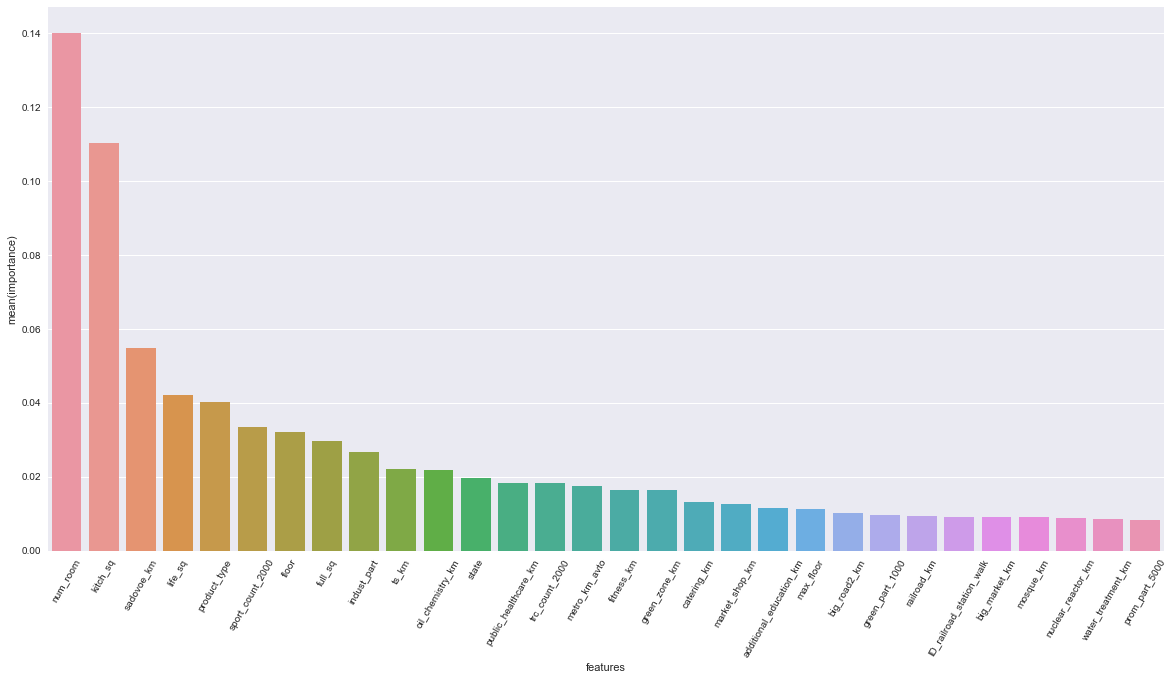

In [129]:
features = pd.DataFrame()
features['features'] = x_train.columns
features['importance'] = clf.feature_importances_
features.sort_values(by=['importance'],ascending=False,inplace=True)
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
plt.xticks(rotation=60)
sns.barplot(data=features.head(30),x="features",y="importance",ax=ax,orient="v")

### Submission

In [137]:
y_predict = clf.predict(x_test)
p_y =np.exp(y_predict)-1
id_test = df_test.id
output = pd.DataFrame({'id': id_test, 'price_doc': p_y})
output.head()

,id,price_doc
0,30474,5.830440e+06
1,30475,7.923287e+06
2,30476,6.352503e+06
3,30477,8.458173e+06
4,30478,5.827255e+06


In [138]:
output.to_csv('./data/output/gradboot_first_try.csv', index=False)

In [ ]:
#VIF method to solve multicolinearty 
from statsmodels.stats.outliers_influence import variance_inflation_factor    

def calculate_vif_(X, thresh=5.0):
    variables = range(X.shape[1])
    dropped=True
    while dropped:
        dropped=False
        vif = [variance_inflation_factor(X[variables].values, ix) for ix in range(X[variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X[variables].columns[maxloc] + '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped=True

    print('Remaining variables:')
    print(X.columns[variables])
    return X[variables]

In [ ]:
train_n_corr.shape

### Comparison of different feature selection